In [1]:
from time import time
start_time = time()

### Imports, Load Data and inspect

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import Queen, Rook, KNN
from spopt.region import MaxPHeuristic as MaxP
import shapely
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import libpysal as ps
import esda
import math

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# BIG DATASET
# Split 1
#pth = r"Y:\Lukas\thesis\bus1123\data\split1\calhouses3310scat-train1-voro1.shp"
#test_p_pth = r"Y:\Lukas\thesis\bus1123\data\split1\calhouses3310scat-test1.shp"

# Split 2
#pth = r"Y:\Lukas\thesis\bus1123\data\split2\calhouses3310scat-train2-voro2.shp"
#test_p_pth = r"Y:\Lukas\thesis\bus1123\data\split2\calhouses3310scat-test2.shp"

# Split 3
#pth = r"Y:\Lukas\thesis\bus1123\data\split3\calhouses3310scat-train3-voro3.shp"
#test_p_pth = r"Y:\Lukas\thesis\bus1123\data\split3\calhouses3310scat-test3.shp"

# SMALL DATASET
# Split 1
pth = r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TRAIN-1_voro.shp"
test_p_pth = r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TEST-1_points.shp"

# Split 2
#pth = r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TRAIN-2_voro.shp"
#test_p_pth = r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TEST-2_points.shp"

# Split 3
#pth = r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TRAIN-3_voro.shp"
#test_p_pth = r"Y:\Lukas\thesis\bus1123\randomsample_houses\houses_random_2050_TEST-3_points.shp"


houses = gpd.read_file(pth)

In [5]:
houses.head(2)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry
0,142600.0,3.0992,9.0,3293.0,840.0,4.342857,1.065476,"POLYGON ((272734.822 -607559.551, 272046.019 -..."
1,96200.0,1.6007,21.0,1327.0,488.0,3.645492,0.954918,"POLYGON ((275235.497 -599843.782, 273503.882 -..."


In [6]:
houses.shape

(1640, 8)

In [7]:
houses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MedHouseVa  1640 non-null   float64 
 1   MedIncome   1640 non-null   float64 
 2   MedianAge   1640 non-null   float64 
 3   Population  1640 non-null   float64 
 4   Households  1640 non-null   float64 
 5   roomsperHH  1640 non-null   float64 
 6   bedroomHH   1640 non-null   float64 
 7   geometry    1640 non-null   geometry
dtypes: float64(7), geometry(1)
memory usage: 102.6 KB


### MAXP Regionalization

In [8]:
houses.shape

(1640, 8)

In [9]:
attribute_name = ['MedHouseVa']

In [10]:
wq = Queen.from_dataframe(houses)
wq.n

C:\Users\lukasb97\AppData\Local\Temp\ipykernel_5492\266690351.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = Queen.from_dataframe(houses)


1640

In [11]:
threshold_value = 65
houses["count"] = 1
threshold_name = "count"

In [12]:
%%time
model = MaxP(houses, wq, attribute_name, threshold_name, threshold_value)
model.solve()

CPU times: total: 5min 5s
Wall time: 5min 5s


In [13]:
column_name = f'maxp_{threshold_value}'
houses[column_name] = model.labels_

In [14]:
pd.set_option('display.max_rows', 300)
houses['number'] = 1
houses[[column_name,'number']].groupby(by=column_name).count()

,number
maxp_65,
1,66
2,66
3,75
4,66
5,66
6,66
7,66
8,88
9,66


<Axes: >

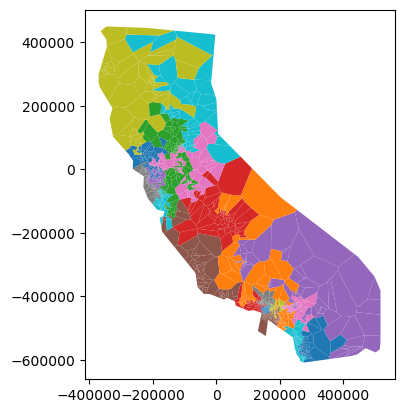

In [15]:
houses.plot(column=column_name, categorical=True)

### Choose best model, then only keep necessary columns

In [16]:
houses.head(1)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,count,maxp_65,number
0,142600.0,3.0992,9.0,3293.0,840.0,4.342857,1.065476,"POLYGON ((272734.822 -607559.551, 272046.019 -...",1,21,1


In [17]:
keepcolumns = ['MedHouseVa', 'MedIncome', 'MedianAge', 'Population', 'Households', 'roomsperHH', 'bedroomHH', 'geometry', 
               'maxp_65']
houses = houses.loc[:, keepcolumns]
houses.head()

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,maxp_65
0,142600.0,3.0992,9.0,3293.0,840.0,4.342857,1.065476,"POLYGON ((272734.822 -607559.551, 272046.019 -...",21
1,96200.0,1.6007,21.0,1327.0,488.0,3.645492,0.954918,"POLYGON ((275235.497 -599843.782, 273503.882 -...",21
2,125000.0,1.7301,5.0,3148.0,855.0,3.164912,1.081871,"POLYGON ((276137.045 -604431.281, 275994.245 -...",21
3,139500.0,3.6736,23.0,1371.0,327.0,5.556575,0.987768,"POLYGON ((269191.311 -606347.166, 269183.834 -...",21
4,139300.0,3.8615,26.0,1145.0,313.0,4.993610,0.913738,"POLYGON ((279114.859 -598990.282, 278765.629 -...",21


## Spatial join the test data

In [18]:
test_p = gpd.read_file(test_p_pth)

In [19]:
test_p.head(2)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796)
1,104200.0,2.1250,16.0,1077.0,520.0,5.046154,1.013462,POINT (60108.280 -192791.957)


In [20]:
test_p.shape

(411, 8)

<Axes: >

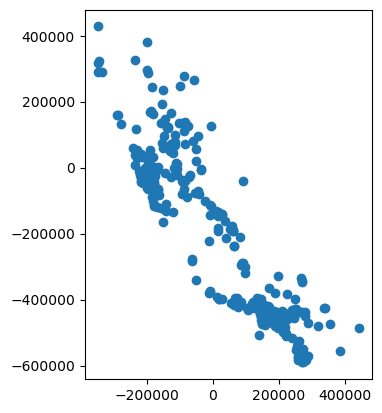

In [21]:
test_p.plot()

In [22]:
# temporary copy so just the columns wanted are in the join
temp_train_gdf = houses[['maxp_65', 'geometry']].copy()

joined_gdf = gpd.sjoin(test_p, temp_train_gdf, how="left", op="within")
joined_gdf = joined_gdf.drop(columns=['index_right'])

# --> provides test data with cluster number

C:\Users\lukasb97\.conda\envs\test\Lib\site-packages\IPython\core\interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [23]:
houses.head(3)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,maxp_65
0,142600.0,3.0992,9.0,3293.0,840.0,4.342857,1.065476,"POLYGON ((272734.822 -607559.551, 272046.019 -...",21
1,96200.0,1.6007,21.0,1327.0,488.0,3.645492,0.954918,"POLYGON ((275235.497 -599843.782, 273503.882 -...",21
2,125000.0,1.7301,5.0,3148.0,855.0,3.164912,1.081871,"POLYGON ((276137.045 -604431.281, 275994.245 -...",21


In [24]:
joined_gdf.head(3)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,maxp_65
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),8
1,104200.0,2.1250,16.0,1077.0,520.0,5.046154,1.013462,POINT (60108.280 -192791.957),8
2,176100.0,2.9000,20.0,1607.0,564.0,4.083333,1.085106,POINT (186008.732 -459723.035),19


<Axes: >

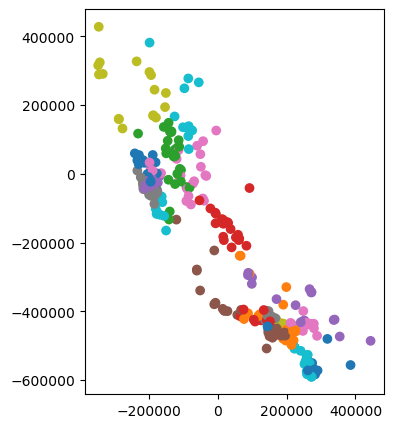

In [25]:
joined_gdf.plot(column='maxp_65', categorical=True, figsize=(5,5))

In [26]:
houses.head(1)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,maxp_65
0,142600.0,3.0992,9.0,3293.0,840.0,4.342857,1.065476,"POLYGON ((272734.822 -607559.551, 272046.019 -...",21


## Variable Definitions for RF models

In [27]:
# Need to replace the maximum value in "maxp_650" column with 0 in the "houses" DataFrame
maxp_65_max_value = houses["maxp_65"].max()
houses["maxp_65"].replace(maxp_65_max_value, 0, inplace=True)

# Need to replace the maximum value in "maxp_650" column with 0 in the "joined_gdf" DataFrame
joined_gdf["maxp_65"].replace(maxp_65_max_value, 0, inplace=True)

In [28]:
# Define labels and weights for loop - change depending on which model gets used
region_labels = houses['maxp_65'].values
region_labels_test = joined_gdf['maxp_65'].values

In [29]:
y_train = houses['MedHouseVa']
y_test = joined_gdf['MedHouseVa']

X_train = houses.drop(["MedHouseVa", "geometry"], axis=1)
X_test = joined_gdf.drop(["MedHouseVa", "geometry"], axis=1)

In [30]:
weights = [len(y_train[region_labels == i]) for i in range(len(np.unique(region_labels)))]

In [31]:
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1640 entries, 0 to 1639
Series name: MedHouseVa
Non-Null Count  Dtype  
--------------  -----  
1640 non-null   float64
dtypes: float64(1)
memory usage: 12.9 KB


In [32]:
y_test.head(1)

0    55000.0
Name: MedHouseVa, dtype: float64

In [33]:
y_train.head(80)

0     142600.0
1      96200.0
2     125000.0
3     139500.0
4     139300.0
5      93200.0
6     125000.0
7     144500.0
8     189700.0
9     127100.0
10    112300.0
11    266600.0
12    118200.0
13    109100.0
14    115800.0
15    267400.0
16    118000.0
17    135000.0
18    103000.0
19    120800.0
20    187500.0
21    133900.0
22    168800.0
23     93200.0
24    130700.0
25    127600.0
26    263600.0
27    114200.0
28    100000.0
29    141400.0
30    298600.0
31    166800.0
32    273500.0
33    159100.0
34    123200.0
35    142000.0
36    210000.0
37    288200.0
38    224200.0
39    159000.0
40    332400.0
41    133700.0
42    137500.0
43    210500.0
44    212000.0
45    169800.0
46    154400.0
47    197000.0
48    112500.0
49    119000.0
50    267000.0
51    184100.0
52    500001.0
53    204200.0
54    166100.0
55    150400.0
56    177200.0
57    158500.0
58    140300.0
59     67500.0
60     63100.0
61     86400.0
62    161500.0
63    176100.0
64    197600.0
65    248400.0
66    3106

In [34]:
X_test.head(1)

,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,maxp_65
0,1.6071,27.0,587.0,231.0,4.190476,1.038961,8


In [35]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1640, 7)
Training Labels Shape: (1640,)
Testing Features Shape: (411, 7)
Testing Labels Shape: (411,)


In [36]:
region_labels.shape

(1640,)

In [37]:
region_labels_test.shape

(411,)

In [38]:
np.unique(region_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int64)

In [39]:
np.unique(region_labels_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int64)

In [40]:
param_dist = {
    'n_estimators': np.arange(50, 210, 10),
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None] + list(np.arange(10, 110, 10)),
    'min_samples_split': np.arange(2, 12),
    'min_samples_leaf': np.arange(1, 5),
    'bootstrap': [True, False]
}

In [41]:
rf = RandomForestRegressor(random_state=42)

## RegRF_CN with Region Number as additional independent variable + HPO

In [42]:
%%time
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, scoring='neg_mean_squared_error', cv=5, n_iter=20, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
CPU times: total: 1.39 s
Wall time: 6.41 s


In [43]:
%%time
hpo_rf = RandomForestRegressor(**random_search.best_params_, random_state=42)
hpo_rf.fit(X_train, y_train)
predictions = hpo_rf.predict(X_test)

CPU times: total: 1.08 s
Wall time: 1.07 s


In [44]:
# Calculate Evaluation Metrics
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'units.')
r2 = round(r2_score(y_test, predictions), 3)
print("R2: ", r2)
mse = mean_squared_error(y_test, predictions)
print("MSE: ", mse)
print("RMSE: ", math.sqrt(mse))

Mean Absolute Error: 48289.47 units.
R2:  0.689
MSE:  4149212152.346475
RMSE:  64414.3784596768


## LISA

In [45]:
test_p['predictions'] = predictions.flatten()
test_p['y_test'] = y_test
test_p['test_res'] = test_p['y_test'] - test_p['predictions']

print(test_p.shape)
test_p.head(1)

(411, 11)


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,predictions,y_test,test_res
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),76872.111111,55000.0,-21872.111111


<Axes: >

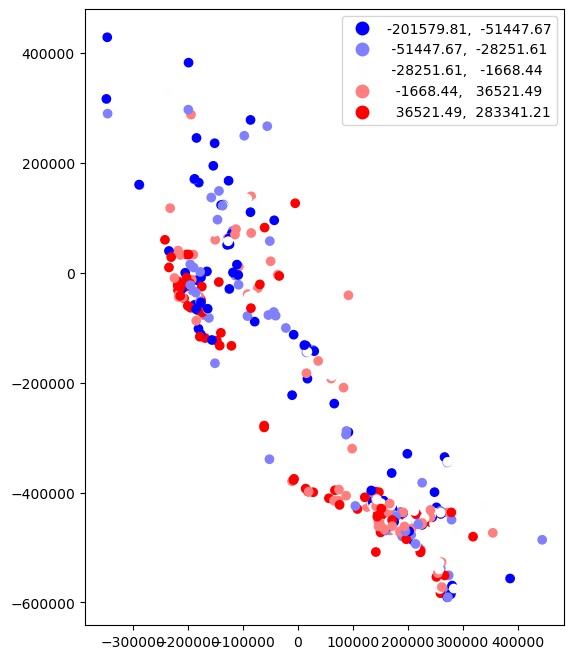

In [46]:
# plot residuals
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'aspect':'equal'})
test_p.plot(column='test_res', scheme='Quantiles', k=5, cmap='bwr', legend=True, ax=ax)

In [47]:
# new spatial weights for moran's I
wi = ps.weights.distance.KNN.from_dataframe(test_p, k=6) 
wi.transform = 'r'
y = test_p['test_res']

In [48]:
mi = esda.Moran(y, wi, permutations = 1000, two_tailed=False)
print( 'Moran I is', round(mi.I, 3), 'and p-value is', mi.p_sim, 'expected value is', mi.EI)

Moran I is 0.22 and p-value is 0.000999000999000999 expected value is -0.0024390243902439024


In [49]:
# Calculate LISA
lisa = esda.moran.Moran_Local(y, wi)

In [50]:
# Calculate spatial groupings and significance
test_p['Is'] = lisa.Is
test_p['pvalue'] = lisa.p_sim 
test_p['group'] = lisa.q 
test_p.loc[test_p['pvalue'] > 0.05, 'group'] = 'not-significant'
test_p.loc[test_p['group'] == 1, 'group'] = 'hotspot'
test_p.loc[test_p['group'] == 2, 'group'] = 'cold outlier'
test_p.loc[test_p['group'] == 3, 'group'] = 'coldspot'
test_p.loc[test_p['group'] == 4, 'group'] = 'hot outlier'
print(test_p ['group'].value_counts())
test_p.head(2)

group
not-significant    311
coldspot            40
hotspot             38
cold outlier        12
hot outlier         10
Name: count, dtype: int64


C:\Users\lukasb97\AppData\Local\Temp\ipykernel_5492\894966211.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'not-significant' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  test_p.loc[test_p['pvalue'] > 0.05, 'group'] = 'not-significant'


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,predictions,y_test,test_res,Is,pvalue,group
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),76872.111111,55000.0,-21872.111111,0.201786,0.022,coldspot
1,104200.0,2.1250,16.0,1077.0,520.0,5.046154,1.013462,POINT (60108.280 -192791.957),98456.444444,104200.0,5743.555556,-0.035256,0.306,not-significant


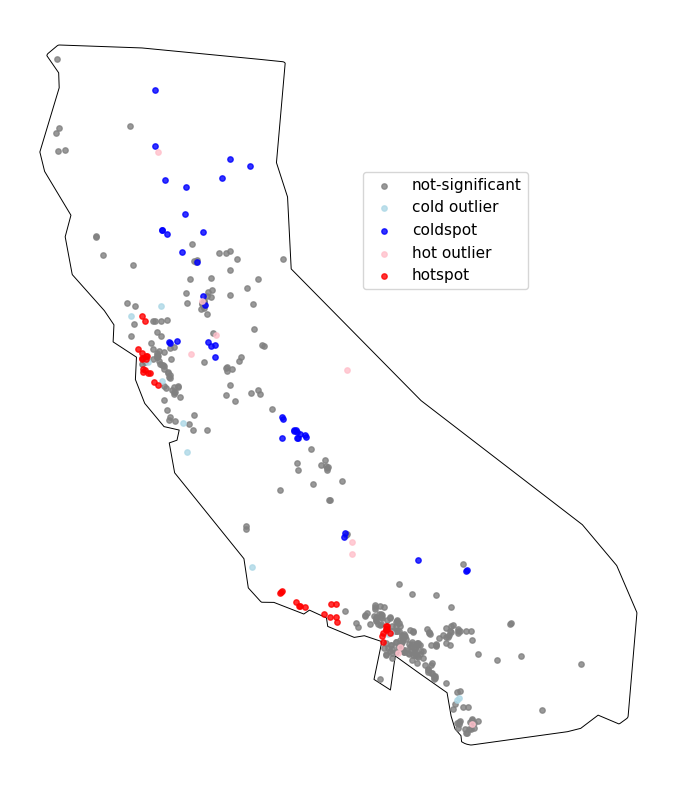

In [51]:
# Vizualize spatial groupings and significance
state_boundary = gpd.read_file(r"Y:/Lukas/thesis/bus1123/bufferedcliprahmen.shp")
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'aspect':'equal'})    

group_colors = {'not-significant': 'grey',
               'hotspot': 'red',
               'coldspot': 'blue',
               'cold outlier': 'lightblue',
               'hot outlier': 'pink'}
#group_colors
state_boundary.plot(ax=ax, edgecolor='black', linewidth=0.7, facecolor='none')

for ctype, data in test_p.groupby('group'):
    if ctype == 'not-significant':
        color = group_colors[ctype]
        data.plot(color=color, ax=ax, label=ctype, markersize=15, alpha=0.8)

for ctype, data in test_p.groupby('group'):
    if ctype != 'not-significant':
        color = group_colors[ctype]
        data.plot(color=color, ax=ax, label=ctype, markersize=15, alpha=0.8)

ax.legend(bbox_to_anchor=(0.8, 0.8), prop={'size': 11})
#ax.set(title='Spatial Groupings')

ax.set_axis_off()
save_path = r'Y:\Lukas\thesis\regionalization plots/lisa_maxp_S3_small.png'
#plt.savefig(save_path)
plt.show()

## RegRF_SEP - Separate RF for each Region - was omitted in the process (might not run, depening on regionalization)

In [ ]:
'''
predictions_list = []
y_test_list = []
residuals_list = []
all_r2 = []
all_mae = []
all_mse = []
all_rmse = []

for i in range(len(np.unique(region_labels))):
    X_region_train = X_train[region_labels == i]
    y_region_train = y_train[region_labels == i]
    X_region_test = X_test[region_labels_test == i]
    y_region_test = y_test[region_labels_test == i]

    rf.fit(X_region_train, y_region_train)

    y_pred = rf.predict(X_region_test)

    # Save results so they can all be analysed together
    predictions_list.extend(y_pred)
    y_test_list.extend(y_region_test)
    residuals_list.extend(y_region_test - y_pred)

    # Same for performance
    r2 = r2_score(y_region_test, y_pred)
    mae = mean_absolute_error(y_region_test, y_pred)
    mse = mean_squared_error(y_region_test, y_pred)
    rmse = np.sqrt(mse)

    all_r2.append(r2)
    all_mae.append(mae)
    all_mse.append(mse)
    all_rmse.append(rmse)

    print(f'Region {i} - R2: {r2:.3f}, MAE: {mae:.3f}, MSE: {mse:.3f}, RMSE: {rmse:.3f}')

# Calculate average errors
avg_r2 = np.mean(all_r2)
avg_mae = np.mean(all_mae)
avg_mse = np.mean(all_mse)
avg_rmse = np.mean(all_rmse)

print(f'\nAverage R2: {avg_r2:.3f}, Average MAE: {avg_mae:.3f}, Average MSE: {avg_mse:.3f}, Average RMSE: {avg_rmse:.3f}')
'''

### LISA

In [ ]:
test_p['predictions'] = predictions_list
test_p['y_test'] = y_test_list
test_p['test_res'] = residuals_list

print(test_p.shape)
test_p.head(1)

In [ ]:
# plot residuals
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'aspect':'equal'})
test_p.plot(column='test_res', scheme='Quantiles', k=5, cmap='bwr', legend=True, ax=ax)

In [ ]:
# new spatial weights for moran's I
wi = ps.weights.distance.KNN.from_dataframe(test_p, k=5) 
wi.transform = 'r'
y = test_p['test_res']

In [ ]:
mi = esda.Moran(y, wi, permutations = 1000, two_tailed=False)
print( 'Moran I is', round(mi.I, 3), 'and p-value is', mi.p_sim, 'expected value is', mi.EI)

In [ ]:
# Calculate LISA
lisa = esda.moran.Moran_Local(y, wi)

In [ ]:
# Calculate spatial groupings and significance
test_p['Is'] = lisa.Is
test_p['pvalue'] = lisa.p_sim 
test_p['group'] = lisa.q 
test_p.loc[test_p['pvalue'] > 0.05, 'group'] = 'not-significant'
test_p.loc[test_p['group'] == 1, 'group'] = 'hotspot'
test_p.loc[test_p['group'] == 2, 'group'] = 'cold outlier'
test_p.loc[test_p['group'] == 3, 'group'] = 'coldspot'
test_p.loc[test_p['group'] == 4, 'group'] = 'hot outlier'
print(test_p ['group'].value_counts())
test_p.head(2)

In [ ]:
# Vizualize spatial groupings and significance
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'aspect':'equal'})    

group_colors = {'not-significant': 'grey',
               'hotspot': 'red',
               'coldspot': 'blue',
               'cold outlier': 'lightblue',
               'hot outlier': 'pink'}
group_colors

for ctype, data in test_p.groupby('group'):
    
    color = group_colors[ctype]
    
    data.plot(color=color, ax=ax, label=ctype)

ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
ax.set(title='Spatial Groupings')

ax.set_axis_off()
plt.show()

## RegRF_W - Multitple Global RFs with more weight on the specific regions (+ HPO)

In [52]:
%%time
test_p['residuals'] = 0
all_residuals = []
all_r2 = []
all_mae = []
all_mse = []
all_rmse = []

# Loop over regions
for i in range(len(np.unique(region_labels))):
    rf_randhpo = RandomForestRegressor(random_state=42, n_jobs=-1)
    rf_randhpo.fit(X_train, y_train, sample_weight=np.where(region_labels == i, weights[i], 1))
    
    y_pred = rf_randhpo.predict(X_test)

    residuals = y_test - y_pred

    all_residuals.append(residuals)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    all_r2.append(r2)
    all_mae.append(mae)
    all_mse.append(mse)
    all_rmse.append(rmse)

    print(f'Region {i} - R2: {r2:.3f}, MAE: {mae:.3f}, MSE: {mse:.3f}, RMSE: {rmse:.3f}')

all_residuals_array = np.array(all_residuals)

average_residuals = np.mean(all_residuals_array, axis=0)

test_p['residuals'] = average_residuals

avg_r2 = np.mean(all_r2)
avg_mae = np.mean(all_mae)
avg_mse = np.mean(all_mse)
avg_rmse = np.mean(all_rmse)

print(f'\nAverage R2: {avg_r2:.3f}, Average MAE: {avg_mae:.3f}, Average MSE: {avg_mse:.3f}, Average RMSE: {avg_rmse:.3f}')

Region 0 - R2: 0.679, MAE: 48325.793, MSE: 4277334732.045, RMSE: 65401.336
Region 1 - R2: 0.659, MAE: 49844.631, MSE: 4547568060.982, RMSE: 67435.659
Region 2 - R2: 0.679, MAE: 47786.516, MSE: 4274710873.433, RMSE: 65381.273
Region 3 - R2: 0.654, MAE: 49843.820, MSE: 4607420678.849, RMSE: 67877.984
Region 4 - R2: 0.677, MAE: 48812.781, MSE: 4302241632.580, RMSE: 65591.475
Region 5 - R2: 0.682, MAE: 48284.770, MSE: 4235546769.356, RMSE: 65081.078
Region 6 - R2: 0.689, MAE: 48019.639, MSE: 4140307327.650, RMSE: 64345.220
Region 7 - R2: 0.691, MAE: 47113.832, MSE: 4119619961.548, RMSE: 64184.266
Region 8 - R2: 0.695, MAE: 46286.742, MSE: 4070515105.452, RMSE: 63800.589
Region 9 - R2: 0.668, MAE: 48523.504, MSE: 4423895521.101, RMSE: 66512.371
Region 10 - R2: 0.711, MAE: 44780.893, MSE: 3848576003.438, RMSE: 62036.892
Region 11 - R2: 0.672, MAE: 48706.277, MSE: 4374907572.288, RMSE: 66143.084
Region 12 - R2: 0.661, MAE: 49087.320, MSE: 4516656066.479, RMSE: 67206.072
Region 13 - R2: 0.672,

### LISA

In [53]:
test_p.head(1)

,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,predictions,y_test,test_res,Is,pvalue,group,residuals
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),76872.111111,55000.0,-21872.111111,0.201786,0.022,coldspot,-24245.782609


In [54]:
test_p['test_res'] = test_p['residuals']

print(test_p.shape)
test_p.head(1)

(411, 15)


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,predictions,y_test,test_res,Is,pvalue,group,residuals
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),76872.111111,55000.0,-24245.782609,0.201786,0.022,coldspot,-24245.782609


<Axes: >

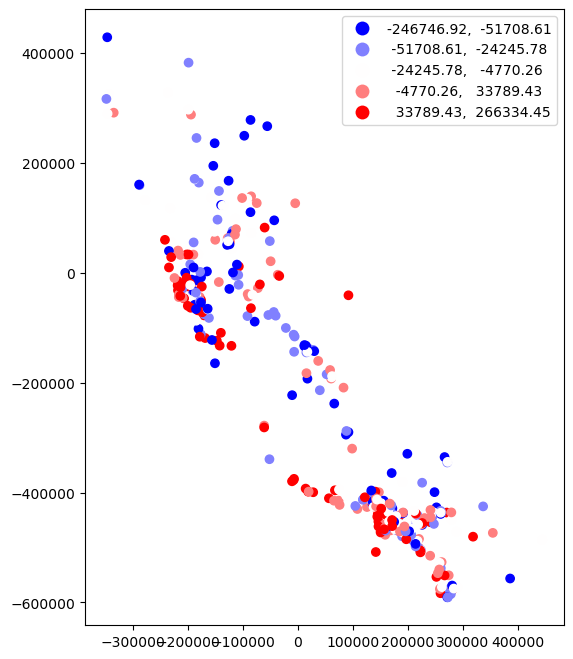

In [55]:
# Global Spatial Autocorrelation
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'aspect':'equal'})
test_p.plot(column='test_res', scheme='Quantiles', k=5, cmap='bwr', legend=True, ax=ax)

In [56]:
# new spatial weights for moran's I
wi = ps.weights.distance.KNN.from_dataframe(test_p, k=5) 
wi.transform = 'r'
y = test_p['test_res']

C:\Users\lukasb97\.conda\envs\test\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [57]:
mi = esda.Moran(y, wi, permutations = 1000, two_tailed=False)
print( 'Moran I is', round(mi.I, 3), 'and p-value is', mi.p_sim, 'expected value is', mi.EI)

Moran I is 0.185 and p-value is 0.000999000999000999 expected value is -0.0024390243902439024


In [58]:
# Calculate LISA
lisa = esda.moran.Moran_Local(y, wi)

In [59]:
# Calculate spatial groupings and significance
test_p['Is'] = lisa.Is
test_p['pvalue'] = lisa.p_sim 
test_p['group'] = lisa.q 
test_p.loc[test_p['pvalue'] > 0.05, 'group'] = 'not-significant'
test_p.loc[test_p['group'] == 1, 'group'] = 'hotspot'
test_p.loc[test_p['group'] == 2, 'group'] = 'cold outlier'
test_p.loc[test_p['group'] == 3, 'group'] = 'coldspot'
test_p.loc[test_p['group'] == 4, 'group'] = 'hot outlier'
print(test_p ['group'].value_counts())
test_p.head(2)

group
not-significant    344
hotspot             32
coldspot            17
hot outlier         11
cold outlier         7
Name: count, dtype: int64


C:\Users\lukasb97\AppData\Local\Temp\ipykernel_5492\894966211.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'not-significant' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  test_p.loc[test_p['pvalue'] > 0.05, 'group'] = 'not-significant'


,MedHouseVa,MedIncome,MedianAge,Population,Households,roomsperHH,bedroomHH,geometry,predictions,y_test,test_res,Is,pvalue,group,residuals
0,55000.0,1.6071,27.0,587.0,231.0,4.190476,1.038961,POINT (-6223.359 -116314.796),76872.111111,55000.0,-24245.782609,0.207033,0.046,coldspot,-24245.782609
1,104200.0,2.1250,16.0,1077.0,520.0,5.046154,1.013462,POINT (60108.280 -192791.957),98456.444444,104200.0,9504.521739,-0.065082,0.294,not-significant,9504.521739


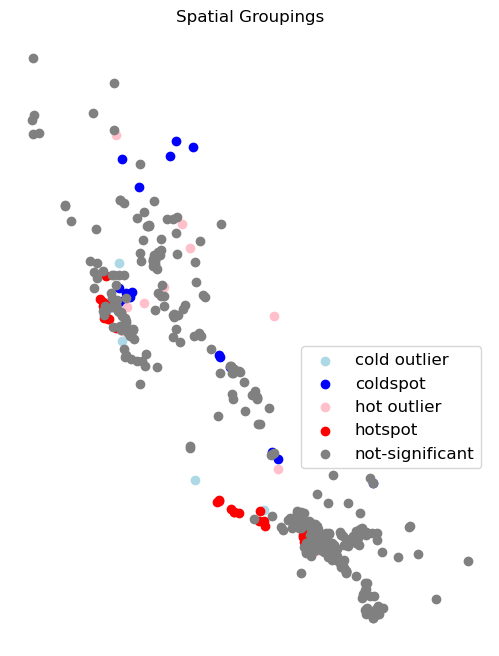

In [60]:
# Vizualize spatial groupings and significance
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'aspect':'equal'})    

group_colors = {'not-significant': 'grey',
               'hotspot': 'red',
               'coldspot': 'blue',
               'cold outlier': 'lightblue',
               'hot outlier': 'pink'}
group_colors

for ctype, data in test_p.groupby('group'):
    
    color = group_colors[ctype]
    
    data.plot(color=color, ax=ax, label=ctype)

ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
ax.set(title='Spatial Groupings')

ax.set_axis_off()
plt.show()

## Runtime

In [61]:
print("Time for whole script: {:.2f} seconds".format(time() - start_time))

Time for whole script: 324.49 seconds
